© 2025 Mobile Perception Systems Lab at TU/e. All rights reserved. Licensed under the MIT License.

## Setup

In [1]:
import os
import csv
import yaml
import gdown
import zipfile
import warnings
import requests
import importlib
from tqdm.auto import tqdm
from typing import Iterable, Any

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import average_precision_score, roc_curve
from datasets.generic_anomaly import GenericAnomalyDataset

import torch
from torch.nn import functional as F
from torch.amp.autocast_mode import autocast

from huggingface_hub import hf_hub_download
from huggingface_hub.utils import RepositoryNotFoundError

from lightning import seed_everything

In [2]:
def fpr_at_95_tpr(scores, labels):
    """
    Calculates the False Positive Rate (FPR) when the True Positive Rate (TPR) is 95%
    """
    fpr, tpr, thresholds = roc_curve(labels, scores)
    if all(tpr < 0.95):
        return 1.0
    # Find the index where TPR is at least 0.95
    idx = np.argmax(tpr >= 0.95)
    return fpr[idx]

def select_device(device_: str) -> torch.device:

    if device_ == "auto":
        if torch.cuda.is_available():
            return torch.device("cuda")
        elif torch.mps.is_available():
            return torch.device("mps")
        else:
            return torch.device("cpu")

    if device_ == "cpu":
        return torch.device("cpu")
    elif device_ == "cuda" and torch.cuda.is_available():
        return torch.device("cuda")
    elif device_ == "mps" and torch.mps.is_available():
        return torch.device("mps")

    print("[WARNING] Device not found or not available. Using CPU.")
    return torch.device("cpu")



def get_cityScape_datasets(datapath: str = ""):
    """
    Downloads the Cityscape datasets into the specified directory if they are not already present.

    :param datapath: Path where the datasets will be stored. If not provided, defaults to "raw_datasets".
    :type datapath: str
    :return: None
    """

    chunk = 10_000_000 # 10 MB chunk
    datapath = datapath or "raw_datasets"
    os.makedirs(datapath, exist_ok=True)

    if len(os.listdir(datapath)):
        print("Cityscape datasets already downloaded")
        return

    s = requests.Session()
    s.post("https://www.cityscapes-dataset.com/login/",
           data={"username":"AdryG","password":"Agf2gc262!","submit":"Login"})

    for pid in [1, 3]:
        r = s.get(f"https://www.cityscapes-dataset.com/file-handling/?packageID={pid}",
                  stream=True, allow_redirects=True)

        r.raise_for_status()

        cd = r.headers.get("content-disposition","")
        fname = cd.split("filename=")[-1].strip('"') if "filename=" in cd else f"{pid}.zip"
        size = int(r.headers.get("content-length", 0))

        with open(f"raw_datasets/{fname}", "wb") as f, tqdm(total=size, unit="B", unit_scale=True, desc=fname) as p:
            for c in r.iter_content(chunk):
                f.write(c); p.update(len(c))


def get_eomt_trained_model():
    """
    Downloads the EOMT trained model from the given Google Drive folder link, extracts its contents,
    and performs cleanup and renaming operations if necessary.

    The function checks if the local folder `eomt_trained_model` exists. If not, it downloads the files
    from the provided URL using the `gdown` library. After downloading the folder, it looks for a zip
    file within the folder, unzips its contents, and skips files related to `macosx`. Additionally, if
    the dataset name contains a typo (e.g., "Obsticle"), it renames it to correct the spelling
    (e.g., "Obstacle").

    :raises zipfile.BadZipFile: If the zip file within the folder is corrupted or invalid.
    :raises OSError: If there is an issue accessing or modifying files or directories.
    :return: None
    """

    # folder link
    url = "https://drive.google.com/drive/folders/1q2vHUzora2nP52fP50zmoQAykWuwoGav?usp=share_link"

    folder_name = "eomt_trained_model"

    if not os.path.exists(folder_name):
        gdown.download_folder(url, output=folder_name, quiet=True)
    else:
        print("EOMT trained model already downloaded")
        return

    zip_path = os.path.join(folder_name, "Validation_Dataset.zip")

    with zipfile.ZipFile(zip_path, 'r') as zip_obj:
        for file_name in zip_obj.namelist():
            if "macosx" in file_name.lower():
                continue
            zip_obj.extract(file_name, folder_name)

    # fix a typo in the dataset name
    for dirname in os.listdir(os.path.join(folder_name, "Validation_Dataset")):
        if "obsticle" in dirname.lower():
            os.rename(os.path.join(folder_name, "Validation_Dataset", dirname), os.path.join(folder_name, "Validation_Dataset", dirname.replace("Obsticle", "Obstacle")))



In [3]:
get_cityScape_datasets()
get_eomt_trained_model()

gtFine_trainvaltest.zip:   0%|          | 0.00/253M [00:00<?, ?B/s]

leftImg8bit_trainvaltest.zip:   0%|          | 0.00/11.6G [00:00<?, ?B/s]

EOMT trained model already downloaded


In [4]:
seed_everything(0, verbose=False)

device = select_device("auto")
img_idx = 2  # change to the index of the image you want to visualize
config_path = "configs/dinov2/cityscapes/semantic/eomt_base_640.yaml"
data_path = "raw_datasets"  # dataset directory

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

def create_mapping(images, ignore_index):
    unique_ids = np.unique(np.concatenate([np.unique(img) for img in images]))
    valid_ids = unique_ids[unique_ids != ignore_index]
    colors = np.array(
        [plt.cm.hsv(i / len(valid_ids))[:3] for i in range(len(valid_ids))]
    )
    mapping = {cid: colors[i] for i, cid in enumerate(valid_ids)}
    mapping[ignore_index] = np.array([0, 0, 0])
    return mapping


def apply_colormap(image, mapping):
    colored_image = np.zeros((*image.shape, 3))
    for cid in np.unique(image):
        colored_image[image == cid] = mapping.get(cid, [0, 0, 0])
    return colored_image

## Load dataset

Ensure the dataset files are correctly prepared and placed in the folder specified by `data_path`.

In [5]:
data_module_name, class_name = config["data"]["class_path"].rsplit(".", 1)
data_module = getattr(importlib.import_module(data_module_name), class_name)
data_module_kwargs = config["data"].get("init_args", {})

data = data_module(
    path=data_path,
    batch_size=1,
    num_workers=0,
    check_empty_targets=False,
    **data_module_kwargs
).setup()

## Load model

In [6]:
warnings.filterwarnings(
    "ignore",
    message=r".*Attribute 'network' is an instance of `nn\.Module` and is already saved during checkpointing.*",
)

# Load encoder
encoder_cfg = config["model"]["init_args"]["network"]["init_args"]["encoder"]
encoder_module_name, encoder_class_name = encoder_cfg["class_path"].rsplit(".", 1)
encoder_cls = getattr(importlib.import_module(encoder_module_name), encoder_class_name)
encoder = encoder_cls(img_size=data.img_size, **encoder_cfg.get("init_args", {}))

# Load network
network_cfg = config["model"]["init_args"]["network"]
network_module_name, network_class_name = network_cfg["class_path"].rsplit(".", 1)
network_cls = getattr(importlib.import_module(network_module_name), network_class_name)
network_kwargs = {k: v for k, v in network_cfg["init_args"].items() if k != "encoder"}
network = network_cls(
    masked_attn_enabled=False,
    num_classes=data.num_classes,
    encoder=encoder,
    **network_kwargs,
)

# Load Lightning module
lit_module_name, lit_class_name = config["model"]["class_path"].rsplit(".", 1)
lit_cls = getattr(importlib.import_module(lit_module_name), lit_class_name)
model_kwargs = {k: v for k, v in config["model"]["init_args"].items() if k != "network"}
if "stuff_classes" in config["data"].get("init_args", {}):
    model_kwargs["stuff_classes"] = config["data"]["init_args"]["stuff_classes"]

model = (
    lit_cls(
        img_size=data.img_size,
        num_classes=data.num_classes,
        network=network,
        **model_kwargs,
    )
    .eval()
    .to(device)
)

## Load pre-trained weights from Hugging Face Hub
The model weights are downloaded from the Hugging Face Hub using the logger name from the config. Make sure you have a working internet connection.

In [7]:
def load_pretrained_model(model_,
                          device_,
                          *,
                          config_=None,
                          local_path=None,
                          repo_namespace="tue-mps",
                          hf_filename="pytorch_model.bin",
                          strict=False,
                          map_location=None,
                          ):

    """
    Load a pretrained model with optional configurations and specified parameters.

    This function attempts to load a pretrained model's weights either from a
    local path or from the HuggingFace Hub. If a configuration object with logger
    information is provided, it attempts to locate and download the model from
    the specified HuggingFace repository. If a mismatch in the positional
    embedding shapes between the model and checkpoint is detected, the positional
    embedding in the state dictionary will be ignored. After loading the state
    dictionary, the model is set to evaluation mode and moved to the specified
    device.

    :param model_: The PyTorch model to load the pretrained weights into.
    :param device_: The device to move the model to after loading the weights.
    :param config_: Optional configuration object containing model and logger settings.
    :param local_path: Optional local file path to a pretrained checkpoint.
    :param repo_namespace: Namespace of the HuggingFace Hub repository where the pretrained model is hosted. Defaults to "tue-mps".
    :param hf_filename: Filename of the pretrained model checkpoint in the repository. Defaults to "pytorch_model.bin".
    :param strict: Whether to enforce strict loading of layers into the model. Defaults to False.
    :param map_location: Device mapping location for loading the checkpoint. Defaults to None.
    :return: The model with loaded pretrained weights, set to evaluation mode and moved to the specified device.
    """

    ckpt_path = local_path or None

    if config_:
        name_ = (config_.get("trainer", {})
                .get("logger", {})
                .get("init_args", {})
                .get("name"))

        if name_:
            try:
                ckpt_path = hf_hub_download(
                    repo_id=f"{repo_namespace}/{name_}",
                    filename=hf_filename)
            except RepositoryNotFoundError:
                warnings.warn(f"Pretrained model `{name_}` not found on HuggingFace Hub")
                return model_.eval().to(device_)

    if not ckpt_path:
        warnings.warn("No checkpoint provided or found")
        return model_.eval().to(device_)

    ckpt = torch.load(ckpt_path, map_location=map_location)

    # Lightning .ckpt
    state_dict_ = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt

    # Drop positional embedding if shape mismatches
    for key in ("network.encoder.backbone.pos_embed", "encoder.backbone.pos_embed"):
        if key in state_dict_ and key in model_.state_dict():
            if state_dict_[key].shape != model_.state_dict()[key].shape:
                del state_dict_[key]

    model_.load_state_dict(state_dict_, strict=strict)
    model_.eval().to(device_)
    return model_



In [8]:
# eomt (via config)
# model = load_pretrained_model(
#     model,
#     device,
#     config_=config,
#     repo_namespace="tue-mps",
#     hf_filename="pytorch_model.bin",
#     map_location=device,
#     strict=False)

# eomt (da .ckpt locale)
model = load_pretrained_model(
    model,
    device,
    local_path="eomt_trained_model/epoch_106-step_19902_eomt.ckpt",
    map_location=device,
    strict=False)


## Semantic inference (pixel-wise classification)

> This inference method also works when applied to a model trained for panoptic segmentation.

Semantic inference computes per-pixel class scores by combining mask and class predictions:

$$
\sum_i p_i(c) \cdot m_i[h, w]
$$

Here, $p_i(c)$ is the class probability for class $c$ (excluding "no object"), and $m_i[h, w]$ is the sigmoid-normalized mask value for query $i$ at pixel $(h, w)$. The final class is selected by taking the argmax over classes.

*This inference method was originally introduced in MaskFormer.*

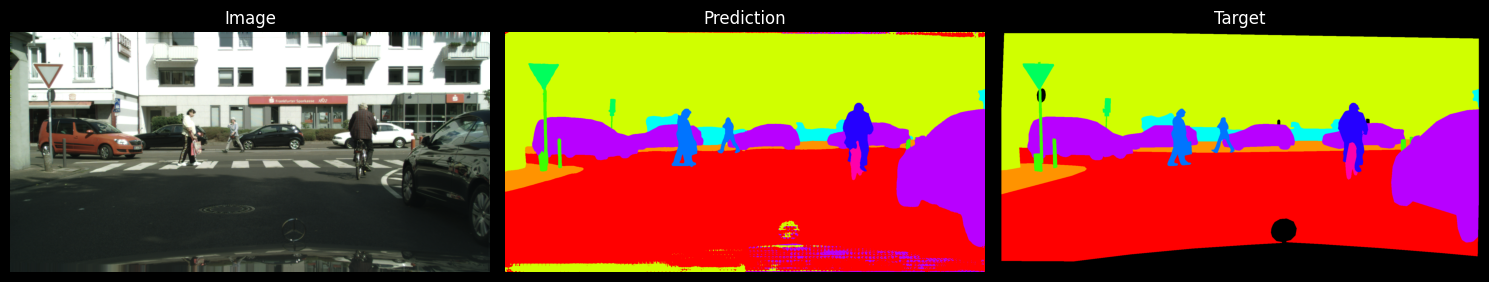

In [10]:
IGNORE_INDEX = 255
DEVICE_TYPE = select_device("auto").type

def infer_semantic(img, target):
    with torch.no_grad(), autocast(dtype=torch.float16, device_type=DEVICE_TYPE):
        imgs = [img.to(device)]
        img_sizes = [img.shape[-2:] for img in imgs]
        crops, origins = model.window_imgs_semantic(imgs)

        mask_logits_per_layer, class_logits_per_layer = model(crops)
        mask_logits = F.interpolate(mask_logits_per_layer[-1], data.img_size, mode="bilinear")

        crop_logits = model.to_per_pixel_logits_semantic(mask_logits, class_logits_per_layer[-1])
        logits = model.revert_window_logits_semantic(crop_logits, origins, img_sizes)
        preds = logits[0].argmax(0).cpu()

    pred_array = preds.numpy()
    target_array = model.to_per_pixel_targets_semantic([target], IGNORE_INDEX)[0].numpy()
    return logits[0], pred_array, target_array


def plot_semantic_results(img, pred_array, target_array):
    mapping = create_mapping([pred_array, target_array], IGNORE_INDEX)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
    axes[0].imshow(img.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Image")
    axes[1].imshow(apply_colormap(pred_array, mapping))
    axes[1].set_title("Prediction")
    axes[2].imshow(apply_colormap(target_array, mapping))
    axes[2].set_title("Target")

    for ax in axes:
        ax.axis("off")

    plt.show()


img, target = data.val_dataloader().dataset[img_idx]
_, pred_array, target_array = infer_semantic(img, target)
plot_semantic_results(img, pred_array, target_array)

In [11]:
def compute_anomaly_maps(logits_chw: torch.Tensor, T: float) -> dict[str, torch.Tensor]:
    """
    Compute pixel-wise anomaly score maps from logits [C,H,W] for a given temperature T
    """

    z = logits_chw / T
    probs = F.softmax(z, dim=0)

    # MSP
    msp = 1. - probs.max(dim=0).values

    # MaxLogit
    maxlogit = -z.max(dim=0).values

    # Entropy
    eps = 1e-12
    entropy = -torch.sum(probs * torch.log(probs + eps), dim=0)

    # RbA (Rejected by All) – per paper: -sum_k sigma(L_k(x)), sigma = tanh
    #
    # With this definition, OOD pixels are expected to receive few positive class votes:
    # the summed activation is small, hence the RbA score is close to 0 (less negative).
    # In contrast, in-distribution (ID) pixels receive stronger class support,
    # resulting in a larger sum and therefore a more negative RbA score.
    #
    # see eq 5:
    # https://openaccess.thecvf.com/content/ICCV2023/papers/Nayal_RbA_Segmenting_Unknown_Regions_Rejected_by_All_ICCV_2023_paper.pdf
    sigma = torch.tanh(torch.relu(z))          # values in [0, 1) for positive logits
    rba = -sigma.sum(dim=0)                    # [H, W]

    return {"MSP": msp, "MaxLogit": maxlogit, "Entropy": entropy, "RbA": rba}


def eval_one_dataset(
        *,
        dataset_name: str,
        dataloader: torch.utils.data.DataLoader,
        Ts: Iterable[float],
        ignore_index: int = IGNORE_INDEX) -> list[dict[str, Any]]:

    """
    Evaluates a semantic segmentation model on a single dataset and computes performance metrics for
    anomaly detection such as Area under Precision-Recall Curve (AuPRC) and the False Positive Rate at
    95% True Positive Rate (FPR95). The evaluation process involves anomaly mapping computation, label
    binarization, and metric aggregation across multiple threshold temperatures.

    :param dataset_name: The name of the dataset being evaluated.
    :type dataset_name: str
    :param dataloader: An object providing batches of images and their associated targets for evaluation.
    :type dataloader: torch.utils.data.DataLoader
    :param Ts: A collection of temperature scaling values to be applied during the computation of anomaly maps.
    :type Ts: Iterable[float]
    :param ignore_index: Labels marked with this index are ignored during evaluation to avoid invalid pixels.
    :type ignore_index: int
    :return: A list of dictionaries containing evaluation results for each threshold temperature and method,
             including the AuPRC and FPR95 metrics for the given dataset and configuration.
    :rtype: list[dict[str, Any]]
    """

    methods = ("MSP", "MaxLogit", "Entropy", "RbA")

    acc_labels: list[np.ndarray] = []
    acc_scores: dict[tuple[str, float], list[np.ndarray]] = {(m, t): [] for m in methods for t in Ts}

    for _img, _target in tqdm(dataloader, desc=f"Evaluating {dataset_name:>20s}"):
        # If DataLoader adds a batch dimension (B, C, H, W), keep only the first sample (we evaluate one image at a time)
        if isinstance(_img, torch.Tensor) and _img.dim() == 4:
            _img = _img[0]

        # If the target is a dict (e.g., {"masks": ..., "labels": ...}), DataLoader collates each value and adds a batch dim, so we remove that leading batch dimension from every tensor in the dict
        if isinstance(_target, dict):
            _target = {k:(v[0] if isinstance(v, torch.Tensor) else v) for k,v in _target.items()}

        # Otherwise, if the target is a tensor with shape (B, H, W), remove the batch dimension (keep the first sample).
        elif isinstance(_target, torch.Tensor) and _target.dim() == 3:
            _target = _target[0]

        logits_chw, _, target_array = infer_semantic(_img, _target)
        logits_cpu = logits_chw.detach().to("cpu", dtype=torch.float32)
        gt = target_array
        valid = (gt != ignore_index)

        if not np.any(valid): continue

        # binarize labels
        y = (gt[valid] == 1).astype(np.uint8)
        acc_labels.append(y)

        # compute a score map for each T and store only valid pixels
        for t in Ts:
            maps = compute_anomaly_maps(logits_cpu, t)
            for m in methods:
                score = maps[m].numpy()[valid].astype(np.float32)
                acc_scores[(m,t)].append(score)

    if not len(acc_labels):
        warnings.warn(f"No valid pixels found for dataset `{dataset_name}`")
        return []

    y_true = np.concatenate(acc_labels, axis=0)

    rows: list[dict[str, Any]] = []
    for t in Ts:
        for m in methods:
            scores = np.concatenate(acc_scores[(m,t)], axis=0)
            auprc = round(average_precision_score(y_true, scores) * 100., 2)
            fpr95 = round(fpr_at_95_tpr(scores, y_true) * 100., 2)

            rows.append({
               "dataset": dataset_name,
               "method": m,
               "T": t,
               "AuPRC": auprc,
               "FPR95": fpr95})

    return rows

def run_all_datasets(
        *,
        dataset_cfg: list[dict[str, Any]],
        Ts: Iterable[float],
        img_size: tuple[int, int],
        batch_size: int,
        num_workers: int,
        out_csv: str) -> str:

    """
    Executes evaluation of multiple datasets and aggregates results into a specified output file.

    This function iterates through a list of dataset configurations, creates datasets and
    data loaders for each configuration, evaluates them, and writes the aggregated results
    to a CSV file. Each dataset is evaluated using a specified list of temperature scaling
    values, and the results include metrics such as AuPRC and FPR95.

    :param dataset_cfg: List of dataset configurations, where each entry specifies
        the configuration for a particular dataset.
    :param Ts: Iterable of temperature scaling values to be used during evaluation.
    :param img_size: Image size as a tuple of integers (height, width).
    :param batch_size: Number of samples per batch.
    :param num_workers: Number of subprocesses to use for data loading.
    :param out_csv: Path to the output CSV file where aggregated results will be saved.
    :return: Path to the output CSV file containing the evaluation results.
    """

    all_rows: list[dict[str, Any]] = []

    for ds_cfg in dataset_cfg:
        ds_name = ds_cfg['name']
        ds = GenericAnomalyDataset(ds_cfg, img_size=img_size)
        dl = torch.utils.data.DataLoader(ds,
                                         batch_size=batch_size,
                                         num_workers=num_workers)

        rows = eval_one_dataset(
            dataset_name=ds_name,
            dataloader=dl,
            Ts=Ts,
            ignore_index=IGNORE_INDEX)

        all_rows.extend(rows)

    os.makedirs(os.path.dirname(out_csv), exist_ok=True)

    with open(out_csv, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["dataset", "method", "T", "AuPRC", "FPR95"])
        writer.writeheader()
        writer.writerows(all_rows)

    return out_csv

In [15]:
# def get_table5_eomt_csv():
#
#     # Table 5: same temperature for all methods
#     Ts = [1]
#
#     anomaly_config_path = "configs/dinov2/common/generic_anomaly.yaml"
#
#     with open(anomaly_config_path, "r") as f:
#         anomaly_cfg = yaml.safe_load(f)
#
#     datasets_cfg = anomaly_cfg["data"]["init_args"]["datasets"]
#     img_size = tuple(anomaly_cfg["data"]["init_args"]["img_size"])
#     num_workers = int(anomaly_cfg["data"]["init_args"]["num_workers"])
#     out_csv = "results/table5_eomt.csv"
#
#     out_csv = run_all_datasets(
#         dataset_cfg=datasets_cfg,
#         Ts=Ts,
#         img_size=img_size,
#         batch_size=1,
#         num_workers=num_workers,
#         out_csv=out_csv)
#
#
# get_table5_eomt_csv()

Evaluating          RoadAnomaly:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating        RoadAnomaly21:   0%|          | 0/10 [00:00<?, ?it/s]

IOStream.flush timed out


Evaluating       RoadObstacle21:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating    FS_LostFound_full:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating            FS_Static:   0%|          | 0/30 [00:00<?, ?it/s]

In [12]:
def get_table5_1_eomt_csv(Ts: list[float] | None = None):
    # Table 6: test different temperatures
    Ts = Ts or [0.25, 0.33, 0.5, 0.67, 0.75, 1.0, 1.1, 1.25, 1.5, 2.0, 3.0, 4.0, 5.0, 8.0]

    anomaly_config_path = "configs/dinov2/common/generic_anomaly.yaml"

    with open(anomaly_config_path, "r") as f:
        anomaly_cfg = yaml.safe_load(f)

    datasets_cfg = anomaly_cfg["data"]["init_args"]["datasets"]
    img_size = tuple(anomaly_cfg["data"]["init_args"]["img_size"])
    num_workers = int(anomaly_cfg["data"]["init_args"]["num_workers"])
    out_csv = "results/table6_eomt.csv"

    out_csv = run_all_datasets(
        dataset_cfg=datasets_cfg,
        Ts=Ts,
        img_size=img_size,
        batch_size=1,
        num_workers=num_workers,
        out_csv=out_csv)

get_table5_1_eomt_csv()

Evaluating          RoadAnomaly:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating        RoadAnomaly21:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating       RoadObstacle21:   0%|          | 0/30 [00:40<?, ?it/s]

Evaluating    FS_LostFound_full:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating            FS_Static:   0%|          | 0/30 [00:20<?, ?it/s]

In [17]:
def compute_miou_eomt(dataloader, num_classes: int, ignore_index: int = 255):
    """
    Compute semantic mIoU on Cityscapes val for EOMT.
    """

    inter = np.zeros(num_classes, dtype=np.int64)
    union = np.zeros(num_classes, dtype=np.int64)

    for img, target in tqdm(dataloader, desc="mIoU (EOMT/Cityscapes val)"):
        # unwrap img if it's a tuple/list
        if isinstance(img, (tuple, list)):
            img = img[0]

        # remove batch dim if present
        if isinstance(img, torch.Tensor) and img.dim() == 4:
            img = img[0]

        if isinstance(target, (tuple, list)):
            target = target[0]

        # normalize target shape/type
        if isinstance(target, dict):
            if isinstance(target.get("masks"), torch.Tensor) and target["masks"].dim() == 4:
                target["masks"] = target["masks"][0]
            if isinstance(target.get("labels"), torch.Tensor) and target["labels"].dim() == 2:
                target["labels"] = target["labels"][0]

        _, pred_array, target_array = infer_semantic(img, target)

        gt = target_array
        pred = pred_array

        valid = (gt != ignore_index)
        if not np.any(valid):
            continue

        gt_v = gt[valid]
        pred_v = pred[valid]

        # per-class intersection / union
        for c in range(num_classes):
            gt_c = (gt_v == c)
            pred_c = (pred_v == c)

            inter[c] += np.logical_and(gt_c, pred_c).sum()
            union[c] += np.logical_or(gt_c, pred_c).sum()

    # IoU per class (only where union>0)
    iou = np.zeros(num_classes, dtype=np.float64)
    valid_classes = union > 0
    iou[valid_classes] = inter[valid_classes] / union[valid_classes]

    miou = iou[valid_classes].mean() if np.any(valid_classes) else 0.0
    return miou, iou, inter, union

val_loader = data.val_dataloader()
mIoU, iou, inter, union = compute_miou_eomt(dataloader=val_loader, num_classes=data.num_classes, ignore_index=IGNORE_INDEX)
print(f"mIoU: {mIoU * 100:.2f}%")

/Volumes/Data/PycharmProjects/MaskArchitectureAnomaly/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


mIoU (EOMT/Cityscapes val):   0%|          | 0/500 [00:00<?, ?it/s]

mIoU: 81.68%


## Panoptic inference (segmentation with instance IDs)

> This inference method also works when applied to a model trained for instance segmentation.

Panoptic inference assigns each pixel $[h, w]$ to the query $i$ that maximizes the product of class and mask confidence:

$$
p_i(c_i) \cdot m_i[h, w]
$$

where $c_i = \arg\max_c \, p_i(c)$ is the most likely class for query $i$. A pixel is assigned to a query only if both the class confidence and mask confidence are high. Pixels assigned to the same query form a segment labeled with $c_i$. "Stuff" segments with the same class are merged; "thing" segments are kept distinct using the query index. Low-confidence and heavily occluded predictions are filtered out.  
  
*This inference method was originally introduced in MaskFormer.*

In [ ]:
# def infer_panoptic(img, target):
#     with torch.no_grad(), autocast(dtype=torch.float16, device_type=device):
#         imgs = [img.to(device)]
#         img_sizes = [img.shape[-2:] for img in imgs]
#
#         transformed_imgs = model.resize_and_pad_imgs_instance_panoptic(imgs)
#         mask_logits_per_layer, class_logits_per_layer = model(transformed_imgs)
#         mask_logits = F.interpolate(
#             mask_logits_per_layer[-1], model.img_size, mode="bilinear"
#         )
#         mask_logits = model.revert_resize_and_pad_logits_instance_panoptic(
#             mask_logits, img_sizes
#         )
#
#         preds = model.to_per_pixel_preds_panoptic(
#             mask_logits,
#             class_logits_per_layer[-1],
#             model.stuff_classes,
#             model.mask_thresh,
#             model.overlap_thresh,
#         )[0].cpu()
#
#     pred = preds.numpy()
#     sem_pred, inst_pred = pred[..., 0], pred[..., 1]
#
#     target_seg = model.to_per_pixel_targets_panoptic([target])[0].cpu().numpy()
#     sem_target, inst_target = target_seg[..., 0], target_seg[..., 1]
#
#     return sem_pred, inst_pred, sem_target, inst_target
#
#
# def draw_black_border(sem, inst, mapping):
#     h, w = sem.shape
#     out = np.zeros((h, w, 3))
#     for s in np.unique(sem):
#         out[sem == s] = mapping[s]
#
#     combined = sem.astype(np.int64) * 100000 + inst.astype(np.int64)
#     border = np.zeros((h, w), dtype=bool)
#     border[1:, :] |= combined[1:, :] != combined[:-1, :]
#     border[:-1, :] |= combined[1:, :] != combined[:-1, :]
#     border[:, 1:] |= combined[:, 1:] != combined[:, :-1]
#     border[:, :-1] |= combined[:, 1:] != combined[:, :-1]
#     out[border] = 0
#     return out
#
#
# def plot_panoptic_results(img, sem_pred, inst_pred, sem_target, inst_target):
#     all_ids = np.union1d(np.unique(sem_pred), np.unique(sem_target))
#     mapping = {
#         s: (
#             [0, 0, 0]
#             if s == -1 or s == model.num_classes
#             else plt.cm.hsv(i / len(all_ids))[:3]
#         )
#         for i, s in enumerate(all_ids)
#     }
#
#     vis_pred = draw_black_border(sem_pred, inst_pred, mapping)
#     vis_target = draw_black_border(sem_target, inst_target, mapping)
#
#     img_np = (
#         img.cpu().numpy().transpose(1, 2, 0) if img.dim() == 3 else img.cpu().numpy()
#     )
#
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
#     axes[0].imshow(img_np)
#     axes[0].set_title("Input")
#     axes[1].imshow(vis_pred)
#     axes[1].set_title("Prediction")
#     axes[2].imshow(vis_target)
#     axes[2].set_title("Target")
#
#     for ax in axes:
#         ax.axis("off")
#
#     plt.show()
#
#
# img, target = data.val_dataloader().dataset[img_idx]
# sem_pred, inst_pred, sem_target, inst_target = infer_panoptic(img, target)
# plot_panoptic_results(img, sem_pred, inst_pred, sem_target, inst_target)